## the code we wrote for creating the data.
## https://github.com/anryabrahamyan/Road_Traffic_Prediction/

# The following file is the second approach which is averaging our observations for each hour.

In [359]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import pmdarima as pm
import numpy as np
from datetime import timedelta 
import tensorflow as tf
from tensorflow.keras.layers import Flatten, LSTM, Input,Embedding,Dense
from tensorflow.keras.models import Model
import tensorflow_addons as tfa
import statistics

## Loading and preprocessing the data

In [360]:
df = pd.read_csv("../dataset/data.csv")
df.datetime = pd.to_datetime(df.datetime,format = "%d/%m/%Y %H:%M:%S")
df.index = df.datetime
df.drop(columns = ['datetime'], inplace = True)
df.head()

,weather_main,weather_desc,temp,feels_like,temp_min,temp_max,pressure,humidity,visibility,wind_speed,...,Motorcycle_0.9,Motorcycle_0.7,Motorcycle_0.5,Motorcycle_0.3,Motorcycle_0.1,Ambulance_0.9,Ambulance_0.7,Ambulance_0.5,Ambulance_0.3,Ambulance_0.1
datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-10 20:44:39,Clouds,broken clouds,8.60,3.60,7.31,10.04,1008,47,10000,13.89,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:49:39,Clouds,broken clouds,8.60,3.60,7.31,10.04,1008,47,10000,13.89,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:54:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:59:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 21:04:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0


In [361]:
for col in ['weather_main','weather_desc']:
    data = pd.get_dummies(df[col])
    df = pd.concat([df,data],axis = 1)
    df.drop(columns = [col],inplace=True)

In [362]:
#fix weird time period
df = df.replace("None", np.nan) 
df.loc[72:144,'Vehicle_0.1'] = np.nan

/tmp/ipykernel_188/3596543675.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[72:144,'Vehicle_0.1'] = np.nan


In [363]:
for col in df.columns:
    df[col] = df[col].astype('float64')

In [364]:
#convert the index to date/time and remove the ones with missing vehicle data
df_cleaned =pd.DataFrame( index=pd.date_range(df.index.min(),df.index.max(),freq='min'))
df_cleaned.index = df_cleaned.index.round(freq='min')
df.index = df.index.round(freq='min')
df_without_na = df[~df['Vehicle_0.1'].isna()]

In [365]:
#add the data to the cleaned dataframe
columns = df.columns.values
for column in columns:
    df_cleaned[column] = np.nan
df_cleaned.loc[df_without_na.index,columns]=df_without_na[columns]

In [366]:
#iteratively fill with the rolling mean
rolling_mean_30 = df_cleaned.copy()
while sum(rolling_mean_30.isna().sum().values)>0:
    rolling_mean_30.fillna(rolling_mean_30.rolling(30, min_periods=1).mean().shift(),inplace=True)
df_cleaned=rolling_mean_30

<AxesSubplot:>

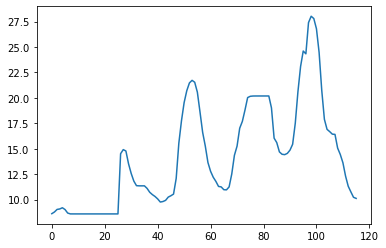

In [367]:
# compute the means for the filled data
df_cleaned['Vehicle_0.1'] = df_cleaned['Vehicle_0.1'].astype(int)
df_cleaned = df_cleaned.groupby([df_cleaned.index.day,df_cleaned.index.hour]).mean().reset_index()
df_cleaned.rename({'level_0':'day','hour':'hour'},inplace=True)
df_cleaned['temp'].plot()

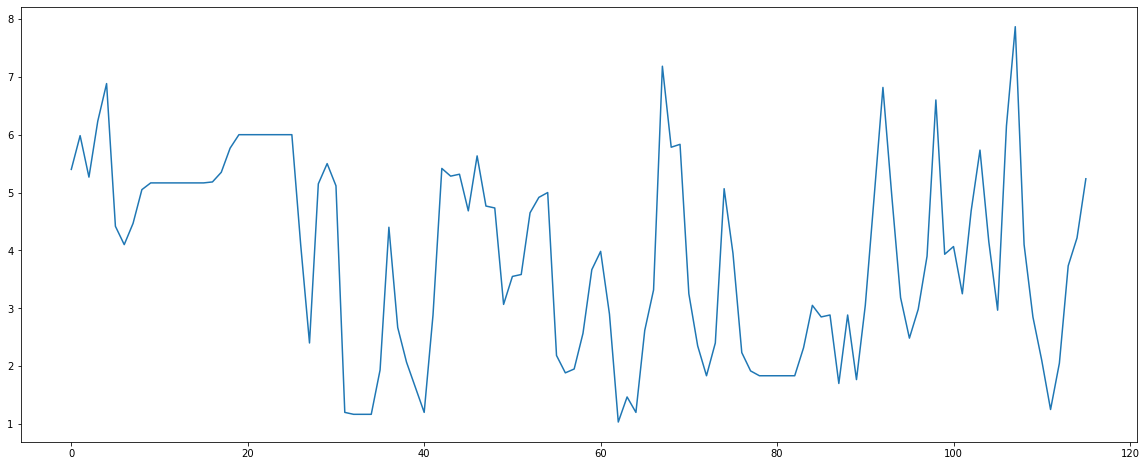

In [368]:
plt.figure(figsize=(20,8))
plt.plot(df_cleaned["Vehicle_0.1"].astype(float))
plt.show()

From the plot we can see that there is no trend, however there is some seasonality because the frequency of the cars decreases after 12am.

In [369]:
X = df_cleaned["Vehicle_0.1"]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.480776
p-value: 0.120222
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581


We can see that p value of ADF statistics is almost 0 which is smaller than 0.05, thus we reject the null hypothesis and conclude that our series is stationary.

In [370]:
result = kpss(X)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('number of lags: %f' % result[2])

print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.506361
p-value: 0.040234
number of lags: 5.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


We have p-value equal to 0.1, which is larger than 0.05, thus we can say that we have stationary time series.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


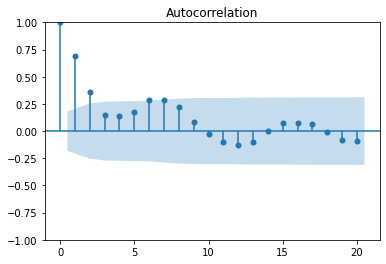

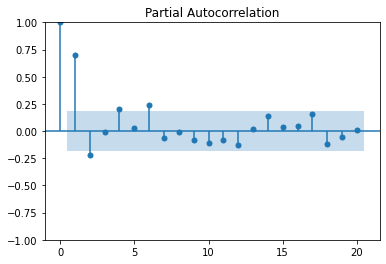

In [371]:
plot_acf(X, lags=20)     
plot_pacf(X, lags=20)     
plt.show()

From the ACF plot we can see that all lags are significant up to lag 3 for the MA process. In PACF we have significant lags until lag 2 and then cuts off, so we will choose lag as 2.

In [372]:
#X = pd.concat([X,X,X])
#X.reset_index(drop= True, inplace = True)

In [373]:
total_observations = len(X)
train = X[:int(0.8*total_observations)]
test = X[int(0.8*total_observations):]

In [374]:
model = ARIMA(train.astype(float),order=(2, 0, 3)).fit()

In [375]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            Vehicle_0.1   No. Observations:                   92
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -136.763
Date:                Wed, 11 May 2022   AIC                            287.525
Time:                        19:06:05   BIC                            305.178
Sample:                             0   HQIC                           294.650
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9232      0.511      7.677      0.000       2.922       4.925
ar.L1          0.8264      0.591      1.398      0.162      -0.333       1.985
ar.L2          0.0486      0.421      0.116      0.9

In [376]:
predictions = model.forecast(len(test))
residuals = test.astype(float) - predictions

Text(0, 0.5, 'Error')

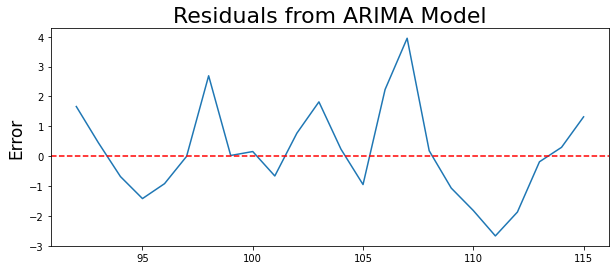

In [377]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals from ARIMA Model', fontsize=22)
plt.ylabel('Error', fontsize=17)

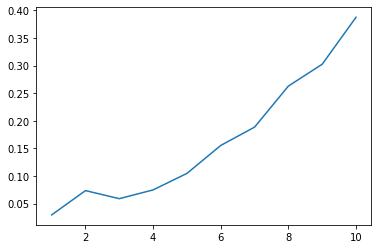

In [378]:
Lj_Box = sm.stats.acorr_ljungbox(residuals, lags = 10,return_df = True)
plt.plot(Lj_Box.index, Lj_Box.lb_pvalue)

The p-values are increasing with the lags, so the model does not capture some of the patterns in the data and the errors are correlated after lag 3(for p-crit = 0.05).

In [379]:
#WE do not consider the seasonal component because the order of dependence for 1 day is 1440 and it will take forever to fit that model. Further aggregations of the data will help with this problem.
model_auto=pm.auto_arima(
    train,
    test='adf',
    max_p = 12,
    max_d = 1,
    max_q = 12,
    seasonal=True,
    m=24,
    max_P=24,
    max_Q=24,
    max_D=1,
    trace=True,
    error_action='ignore', 
    suppress_warnings=True,
    stepwise=True,
    n_fits=120,
    maxiter=11,
    n_jobs=-1)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=285.314, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=293.506, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=293.656, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=292.735, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=291.507, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=283.761, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=287.577, Time=0.11 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=285.754, Time=1.14 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=284.054, Time=0.50 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=287.475, Time=1.38 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=282.475, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=286.496, Time=0.08 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=284.946, Time=0.47 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=284.483, Time=1.02 sec
 ARIMA(1,1,2)(1,0,0)[24] intercep

In [380]:
print('MSE of the AUTOARIMA model is', np.mean((model_auto.predict(len(test))-test.astype("float"))**2))

MSE of the AUTOARIMA model is 6.25589902583308


In [381]:
print('MSE of the previously chosen model is', np.mean((model.forecast(len(test)) - test.astype("float")) **2))

MSE of the previously chosen model is 2.350160349500934


We can observe that the MSE of the previously chosen model is lower, meaning that it is better if we take into consideration MSEs. This procedure might be incorrect because autoarima minimized the AIC and not the MSE, but the autoarima also included the seasonality of 24 hours, so this is a sign that there is little information in knowing the same number of cars for the previous day.

In [382]:
model = ARIMA(train.astype(float),order=(0,1,3), seasonal_order = (0, 0, 1, 24)).fit()
predictions = model.forecast(24)#24 hours

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [383]:
print('MSE of the SARIMA ', np.mean((model.forecast(len(test)) - test.astype("float")) **2))

MSE of the SARIMA  3.9802618456248973


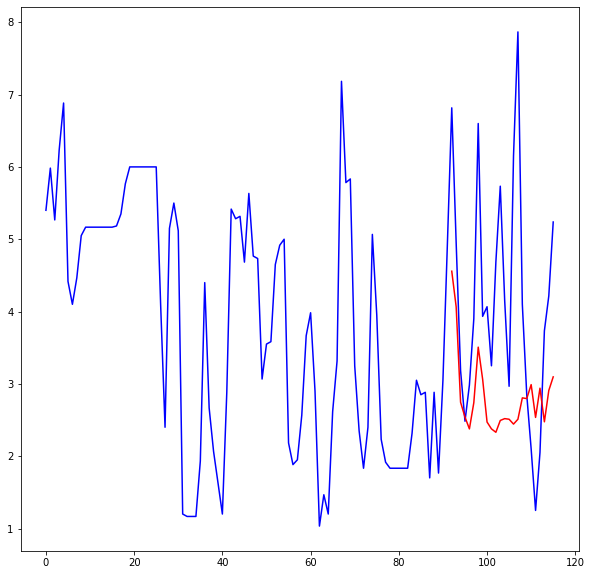

In [384]:
fig = plt.figure(figsize = (10,10))
plt.plot(X,'blue')
plt.plot(predictions,c='red')
plt.show()

In [411]:
exp_smooth = ExponentialSmoothing(train.astype(float),trend=None, seasonal = 'add',initialization_method='estimated',seasonal_periods=24).fit()

## Car traffic is generally stationary in terms of trend, and the seasonality is additive because the variance is not increasing over time.

In [412]:
predictions = exp_smooth.forecast(len(test))
print('MSE of the exp_smoothing model is', np.mean((predictions.values-test.astype("float"))**2))

MSE of the exp_smoothing model is 4.554172989795883


In [413]:
print('MAE of the exp_smoothing is', np.mean(abs(predictions-test.astype("float"))))

MAE of the exp_smoothing is 1.500550727441056


## The exponential smoothing model is worse than the Arima model from before.

In [387]:
exp_smooth = ExponentialSmoothing(train.astype(float),trend=None, seasonal = 'add',initialization_method='estimated',seasonal_periods=24).fit()

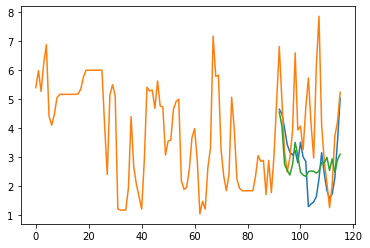

In [388]:
ax = plt.subplot()
ax.plot(exp_smooth.forecast(24))
ax.plot(X.astype(float))
ax.plot(model.forecast(24))
#ax.plot(predictions)

plt.show()

In [419]:
size = int(len(X) * 0.8)
train_new, test_new = list(X[0:size]), list(X[size:len(X)])

history = [x for x in train_new]
predictions = list()

In [420]:
# walk-forward validation
for t in range(len(test_new)):
    model_new = ARIMA(history, order=(0,1,3), seasonal_order = (0, 0, 1, 24))
    model_fit = model_new.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_new[t]
    history.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, obs))

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


predicted=4.557805, expected=6.816667
predicted=4.066759, expected=4.950000
predicted=2.741694, expected=3.183333
predicted=2.533416, expected=2.483333
predicted=2.368267, expected=2.983333
predicted=2.737817, expected=3.900000
predicted=3.518260, expected=6.600000
predicted=3.058628, expected=3.933333
predicted=2.451614, expected=4.066667
predicted=2.356656, expected=3.250000
predicted=2.304105, expected=4.683333
predicted=2.472871, expected=5.733333
predicted=2.499086, expected=4.150000
predicted=2.487979, expected=2.966667
predicted=2.413507, expected=6.150000
predicted=2.479828, expected=7.866667
predicted=2.798680, expected=4.100000
predicted=2.787161, expected=2.850000
predicted=3.002070, expected=2.100000
predicted=2.515622, expected=1.250000
predicted=2.946420, expected=2.050000
predicted=2.447586, expected=3.733333
predicted=2.918057, expected=4.216667
predicted=3.086313, expected=5.238095


In [408]:
Rolling = train_new + predictions

In [409]:
print('MSE of the Rolling ARIMA is', np.mean((predictions-test_new.astype("float"))**2))

MSE of the Rolling ARIMA is 4.024557278615236


In [410]:
print('MAE of the Rolling ARIMA is', np.mean(abs(predictions-test_new.astype("float"))))

MAE of the Rolling ARIMA is 1.5805395877067712


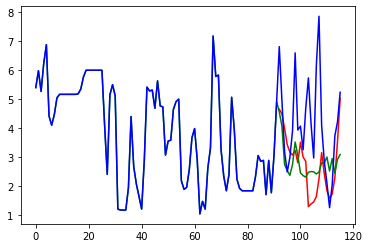

In [250]:
ax = plt.subplot()
ax.plot(exp_smooth.forecast(24),color = "red")
ax.plot(Rolling, color = "green")
ax.plot(df_cleaned["Vehicle_0.1"], color = "blue")

plt.show()

In [251]:
tf.config.experimental_run_functions_eagerly(True)

In [252]:
train_shifted = df_cleaned["Vehicle_0.1"].shift(-1)

In [253]:
train_shifted.dropna(inplace = True)

In [254]:
df_cleaned.drop(columns = ["level_0", "level_1"], inplace = True)

In [255]:
df_cleaned = df_cleaned.iloc[:-1]

In [302]:
X_train = df_cleaned.iloc[:int(0.8 * len(df_cleaned))]
X_test = df_cleaned.iloc[int(0.8*len(df_cleaned)):]
y_train = train_shifted.iloc[:int(0.8 * len(train_shifted))]
y_test = train_shifted.iloc[int(0.8*len(train_shifted)):]

In [320]:
deep_inputs = Input(shape=(76))
inputs = tf.keras.layers.Reshape([1, 76])(deep_inputs)
LSTM_Layer_1 = LSTM(
    units = 120,
    activation="tanh",
    name = 'lstm_layer_1',
    recurrent_activation="sigmoid",
    use_bias=True,
    dropout=0.1,
    return_sequences=True)(inputs)
dense = tf.keras.layers.Dense(1)(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense)

model.compile(loss=tf.keras.losses.MSE,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [321]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 76)]              0         
                                                                 
 reshape_9 (Reshape)         (None, 1, 76)             0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 1, 100)            70800     
                                                                 
 dense_13 (Dense)            (None, 1, 1)              101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [323]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 32, epochs = 10, workers = -1)


Epoch 1/10
1/3 [=========>....................] - ETA: 0s - loss: 11.7167

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 0s 91ms/step - loss: 11.9392 - val_loss: 8.0404
Epoch 2/10
1/3 [=========>....................] - ETA: 0s - loss: 7.4539

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 0s 68ms/step - loss: 7.3149 - val_loss: 5.2650
Epoch 3/10
3/3 [==============================] - 0s 70ms/step - loss: 4.8790 - val_loss: 3.6207
Epoch 4/10
3/3 [==============================] - 0s 57ms/step - loss: 3.5803 - val_loss: 2.7155
Epoch 5/10
3/3 [==============================] - 0s 75ms/step - loss: 2.9431 - val_loss: 2.3833
Epoch 6/10
3/3 [==============================] - 0s 64ms/step - loss: 3.1017 - val_loss: 2.3955
Epoch 7/10
3/3 [==============================] - 0s 65ms/step - loss: 3.1222 - val_loss: 2.4845
Epoch 8/10
3/3 [==============================] - 0s 67ms/step - loss: 3.1451 - val_loss: 2.5272
Epoch 9/10
3/3 [==============================] - 0s 54ms/step - loss: 3.2246 - val_loss: 2.4791
Epoch 10/10
3/3 [==============================] - 0s 73ms/step - loss: 3.1435 - val_loss: 2.4161


In [324]:
model.predict(X_test)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([[[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]],

       [[4.2511587]]], dtype=float32)

In [325]:
X_train1 = X_train.copy()
pred = []
for i in range(1, len(X_test)):
    model.fit(pd.concat([X_train, X_test.iloc[:i]]), pd.concat([y_train, y_test.iloc[:i]]), validation_data = (X_test, y_test), batch_size = 32, epochs = 1, workers = -1)
    pred.append(model.predict([X_test.iloc[i - 1].to_numpy().reshape(1, 76)], batch_size=1))
pred

3/3 [==============================] - ETA: 0s - loss: 2.9850

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 0s 148ms/step - loss: 2.9850 - val_loss: 2.3713


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - ETA: 0s - loss: 2.8866

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 0s 95ms/step - loss: 2.8866 - val_loss: 2.3653


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

3/3 [==============================] - 0s 65ms/step - loss: 2.9974 - val_loss: 2.3970


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

3/3 [==============================] - 0s 84ms/step - loss: 2.8134 - val_loss: 2.4502


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/4 [=====================>........] - ETA: 0s - loss: 2.7636

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/4 [=====================>........] - ETA: 0s - loss: 2.9379

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 72ms/step - loss: 2.9190 - val_loss: 2.5999


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

1/4 [======>.......................] - ETA: 0s - loss: 3.5128

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 49ms/step - loss: 2.7975 - val_loss: 2.3810


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 72ms/step - loss: 2.8878 - val_loss: 2.3622


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 80ms/step - loss: 2.8110 - val_loss: 2.3623


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 83ms/step - loss: 2.7452 - val_loss: 2.3961


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/4 [=====================>........] - ETA: 0s - loss: 2.8081

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 66ms/step - loss: 2.7773 - val_loss: 2.4438


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/4 [=====================>........] - ETA: 0s - loss: 2.7594

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/4 [======>.......................] - ETA: 0s - loss: 2.4393

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 47ms/step - loss: 2.7476 - val_loss: 2.3788


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 73ms/step - loss: 2.8518 - val_loss: 2.3731


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

1/4 [======>.......................] - ETA: 0s - loss: 3.0142

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

1/4 [======>.......................] - ETA: 0s - loss: 2.3709

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 56ms/step - loss: 2.7825 - val_loss: 2.3860


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 48ms/step - loss: 2.8078 - val_loss: 2.3938


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 68ms/step - loss: 2.8472 - val_loss: 2.3985


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 54ms/step - loss: 2.9272 - val_loss: 2.3805


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does

4/4 [==============================] - 0s 76ms/step - loss: 2.8594 - val_loss: 2.3701


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[array([[[4.1144004]]], dtype=float32),
 array([[[3.9627383]]], dtype=float32),
 array([[[3.832365]]], dtype=float32),
 array([[[3.722321]]], dtype=float32),
 array([[[3.611594]]], dtype=float32),
 array([[[3.5314462]]], dtype=float32),
 array([[[3.675656]]], dtype=float32),
 array([[[3.8818963]]], dtype=float32),
 array([[[4.019784]]], dtype=float32),
 array([[[4.008306]]], dtype=float32),
 array([[[3.834745]]], dtype=float32),
 array([[[3.7332816]]], dtype=float32),
 array([[[3.7887936]]], dtype=float32),
 array([[[3.8899908]]], dtype=float32),
 array([[[3.9146001]]], dtype=float32),
 array([[[3.9453177]]], dtype=float32),
 array([[[3.896298]]], dtype=float32),
 array([[[3.8647285]]], dtype=float32),
 array([[[3.8412127]]], dtype=float32),
 array([[[3.8285024]]], dtype=float32),
 array([[[3.8837435]]], dtype=float32),
 array([[[3.9302397]]], dtype=float32)]

In [415]:
pred_all = []
for i in range(len(pred)):
    pred_all.append(pred[i][0][0][0])
pred_all.append(statistics.mean(pred_all))

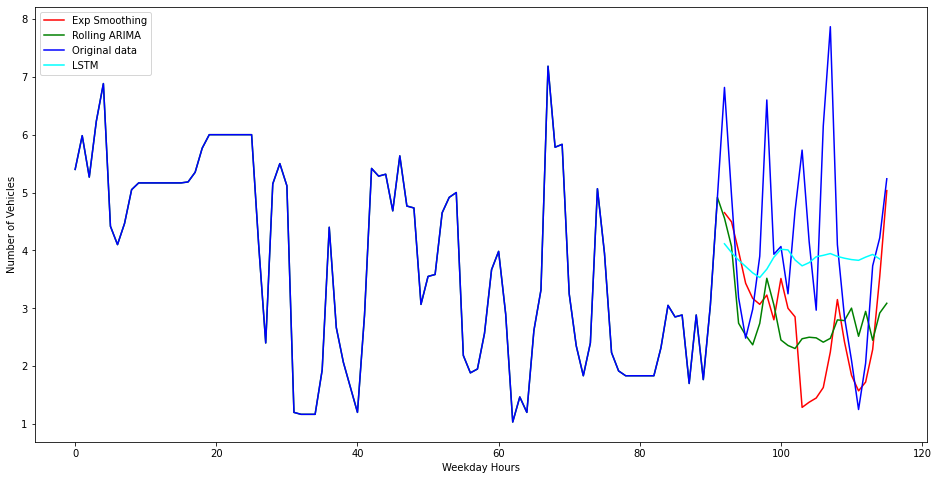

In [400]:
f, ax = plt.subplots(figsize = (16, 8))
ax.plot(exp_smooth.forecast(24),color = "red", label = "Exp Smoothing")
ax.plot(Rolling, color = "green", label = "Rolling ARIMA")
ax.plot(df_cleaned["Vehicle_0.1"], color = "blue", label = "Original data")
plt.plot(X_test.index, pred_all, color = "cyan", label = "LSTM")
plt.xlabel("Weekday Hours")
plt.ylabel("Number of Vehicles")
plt.legend()
plt.show()

#plt.savefig('pred.png')

In [402]:
pred_all.append(statistics.mean(pred_all))

In [417]:
print('MSE of the LSTM is', np.mean((pred_all-y_test.astype("float"))**2))

MSE of the LSTM is 2.419159184108995


In [418]:
print('MAE of the LSTM is', np.mean(abs(pred_all-y_test.astype("float"))))

MAE of the LSTM is 1.193763679105549
